In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

# from tf_agents.environments import suite_gym
# from tf_agents.environments import tf_py_environment
# from tf_agents.policies import random_py_policy
# from tf_agents.policies import random_tf_policy
# from tf_agents.metrics import py_metrics
# from tf_agents.metrics import tf_metrics
# from tf_agents.drivers import py_driver
# from tf_agents.drivers import dynamic_episode_driver
# from tf_agents.drivers import dynamic_step_driver
# from tf_agents.environments import suite_gym
# from tf_agents.environments import tf_py_environment
# from tf_agents.networks import q_network
# from tf_agents.agents.dqn import dqn_agent

import abc
from tf_agents.agents import tf_agent
from tf_agents.drivers import driver
from tf_agents.environments import py_environment
from tf_agents.environments import tf_environment
from tf_agents.environments import tf_py_environment
from tf_agents.policies import tf_policy
from tf_agents.specs import array_spec
from tf_agents.specs import tensor_spec
from tf_agents.trajectories import time_step as ts
from tf_agents.trajectories import trajectory
from tf_agents.trajectories import policy_step
from tf_agents.replay_buffers import py_uniform_replay_buffer
from tf_agents.replay_buffers import tf_uniform_replay_buffer

from keras.datasets import cifar10
from keras.applications import VGG16
from keras import layers, models
from keras.optimizers.legacy import Adam
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split

import os
print(os.getcwd())

nest = tf.nest

/Users/misszhao/Desktop/School code/FYP/contextual_bandit/contextualbandits/contextualbandits


In [2]:
class BanditPyEnvironment(py_environment.PyEnvironment):

  def __init__(self, observation_spec, action_spec):
    self._observation_spec = observation_spec
    self._action_spec = action_spec
    super(BanditPyEnvironment, self).__init__()

  # Helper functions.
  def action_spec(self):
    return self._action_spec

  def observation_spec(self):
    return self._observation_spec

  def _empty_observation(self):
    return tf.nest.map_structure(lambda x: np.zeros(x.shape, x.dtype),
                                 self.observation_spec())

  # These two functions below should not be overridden by subclasses.
  def _reset(self):
    """Returns a time step containing an observation."""
    return ts.restart(self._observe()) #batch_size=self.batch_size

  def _step(self, action):
    """Returns a time step containing the reward for the action taken."""
    reward = self._apply_action(action)
    return ts.termination(self._observe(), reward)

  # These two functions below are to be implemented in subclasses.
  @abc.abstractmethod
  def _observe(self):
    """Returns an observation."""

  @abc.abstractmethod
  def _apply_action(self, action):
    """Applies `action` to the Environment and returns the corresponding reward.
    """

In [3]:
class Node:
    def __init__(self, node_id, x_train, y_train, noise_factor=0.1,noise_bool = 0):
        self.node_id = node_id
        self.x_train = x_train
        self.y_train = y_train
        self.x_train_noisy = None
        self.model = None
        self.best_model = None
        self.accuracy = 0.0
        self.noise_factor = noise_factor
        self.noise_bool = noise_bool

    def create_vgg16_model(self):
        base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
        model = models.Sequential()
        model.add(base_model)
        model.add(layers.Flatten())
        model.add(layers.Dense(256, activation='relu'))
        model.add(layers.Dropout(0.5))
        model.add(layers.Dense(10, activation='softmax'))
        return model
    
    def set_noise_boolean(self, noise_bool):
        self.noise_bool = noise_bool
        
    def introduce_gaussian_noise(self):
        noise = np.random.normal(loc=0.0, scale=self.noise_factor, size=self.x_train.shape)
        self.x_train_noisy = np.clip(self.x_train + noise, 0.0, 255.0)

    def train(self):
        print(f"\nTraining on Node {self.node_id}")
        if self.model is not None:
            print("Model already exists")
            # Initialize the model with the weights of the best model from the previous round
            self.model = models.clone_model(self.best_model)
            self.model.set_weights(self.best_model.get_weights())
        else:
            print("Creating a new model")
            self.model = self.create_vgg16_model()

        if self.noise_bool:
            self.introduce_gaussian_noise()
            self.x_train = self.x_train_noisy
        # Compile the model
        self.model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

        # Define a checkpoint callback :
        checkpoint = ModelCheckpoint(f'best_model{self.node_id}.h5', monitor='val_accuracy', mode='auto', save_best_only=True, verbose=1)
        # Train the model and update the accuracy
        #if self.noise_bool:
            #print(self.x_train_noisy,self.x_train)
        self.model.fit(self.x_train, self.y_train, epochs=10, validation_split=0.2, batch_size=128, callbacks=[checkpoint])
        loss, self.accuracy = self.model.evaluate(self.x_train_noisy, self.y_train)
        # else:
        #     self.model.fit(self.x_train, self.y_train, epochs=10, validation_split=0.2, batch_size=128, callbacks=[checkpoint])
        #     loss, self.accuracy = self.model.evaluate(self.x_train, self.y_train)
        # Load the best model
        self.best_model = tf.keras.models.load_model(f'best_model{self.node_id}.h5')
        #loss,self.accuracy = self.model.evaluate(self.x_train, self.y_train)
        
    # def evaluate(self, federated_average):
    #     # Set the weights of the model to the federated average
    #     self.model.set_weights(federated_average)

    #     # Evaluate the model on the node's data
    #     loss, accuracy = self.model.evaluate(self.x_train, self.y_train)

    #     # Return the accuracy
    #     return accuracy
    
    def get_weights(self):
        if self.model is not None:
            return self.model.get_weights()
        else:
            return None


In [4]:
class NodeTrainingEnvironment(BanditPyEnvironment):
    def __init__(self, nodes,cluster, x_check, y_check):
        self.nodes = nodes #nodes 1 to 3
        #self.include = [1,1,1,0,0,0] # node 4-6 not included
        # self.current_step = 0
        # self.max_steps = 10
        self.current_node = None
        self.cluster = cluster
        self.previous_accuracy = 0.0
        self.action = None
        self.x_check, self.y_check = x_check, y_check
        self.federated_node = Node(node_id=999, x_train=x_check, y_train=y_check, noise_factor=0.0,noise_bool = 0) #created a federated node to check federated model
        self.federated_node.model = self.federated_node.create_vgg16_model()
        self.federated_node.model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        observation_spec = array_spec.BoundedArraySpec(shape=(1,), dtype=np.float32, minimum=0, maximum=1, name='observation')
        action_spec = array_spec.BoundedArraySpec(shape=(),minimum=0,maximum=3, dtype=np.int32,name='action') #chanage this to 0-3 where 3 means do nothing
        
        super(NodeTrainingEnvironment, self).__init__(observation_spec, action_spec)
        self.federated_average_accuracy = self.calculate_federated_average(self.nodes)
    
    def _observe(self):
        return np.array([self.federated_average_accuracy], dtype=np.float32)

    def _apply_action(self,action):
        node = 0 # replace action with 0
        action = 0
        if action == 3:
            print("Do nothing")
        else:
            print("Node selected: ", action+4)
        self.previous_accuracy = self.federated_average_accuracy
        if action == 3:
            self.federated_average_accuracy = self.calculate_federated_average(self.nodes)
            print([i.node_id for i in self.nodes])   
        else: 
            self.federated_average_accuracy = self.calculate_federated_average(self.nodes+[self.cluster[node]])
            print([i.node_id for i in self.nodes+[self.cluster[node]]])   
         
        if self.federated_average_accuracy > self.previous_accuracy:
            print("Accuracy improved")
            return self.federated_average_accuracy - self.previous_accuracy
        elif self.federated_average_accuracy == self.previous_accuracy:
            print("Accuracy did not change")
            return 0
        else:
            print("Accuracy did not improve")
            return self.federated_average_accuracy - self.previous_accuracy 
            
        # Calculate the federated average and evaluate the federated model
        # Update the previous accuracy

    def calculate_federated_average(self,list_of_nodes):
         # Get the weights of all nodes
        for node in list_of_nodes:
            print(node.node_id)
            node.train()
        # Get the weights from each node
        weights = [node.get_weights() for node in list_of_nodes]
        # Make sure all nodes have the same number of layers
        assert all(len(w) == len(weights[0]) for w in weights)
        fed_weights = [np.mean([w[i] for w in weights], axis=0) for i in range(len(weights[0]))]#federated_accuracy = federated_average_weight.evaluate(x_check, y_check)
        # Calculate the average of the weights then the accuracy
        self.federated_node.model.set_weights(fed_weights)
        for node in list_of_nodes:
            #node.model.set_weights(fed_weights)
            node.best_model.set_weights(fed_weights)
        print("Testing on evaluation data:")
        loss, accuracy = self.federated_node.model.evaluate(self.x_check, self.y_check)
        return accuracy
    

In [5]:

# Load CIFAR-10 dataset
(x_train, y_train), _ = cifar10.load_data()

# Shuffle first (optional)
idx = np.arange(len(x_train))
# np.random.shuffle(idx)

# get first 5% of data
x_train = x_train[:int(.05*len(idx))]
y_train = y_train[:int(.05*len(idx))]

# Split the dataset into three equal parts
x_train1, x_train2, y_train1, y_train2 = train_test_split(x_train, y_train, test_size=6/7, random_state=42)
x_train2, x_train3, y_train2, y_train3 = train_test_split(x_train2, y_train2, test_size=5/6, random_state=42)
x_train3, x_train4, y_train3, y_train4 = train_test_split(x_train3, y_train3, test_size=4/5, random_state=42)
x_train4, x_train5, y_train4, y_train5 = train_test_split(x_train4, y_train4, test_size=3/4, random_state=42)
x_train5, x_train6, y_train5, y_train6 = train_test_split(x_train5, y_train5, test_size=2/3, random_state=42)
x_train6, x_check, y_train6, y_check = train_test_split(x_train6, y_train6, test_size=1/2, random_state=42)

# Create Node instances for each portion with different noise factors
node1 = Node(node_id=1, x_train=x_train1, y_train=y_train1, noise_factor=0.0,noise_bool = 0)
node2 = Node(node_id=2, x_train=x_train2, y_train=y_train2, noise_factor=0.0,noise_bool = 0)
node3 = Node(node_id=3, x_train=x_train3, y_train=y_train3, noise_factor=0.0,noise_bool = 0)
node4 = Node(node_id=4, x_train=x_train4, y_train=y_train4, noise_factor=25,noise_bool = 0)
node5 = Node(node_id=5, x_train=x_train5, y_train=y_train5, noise_factor=0.0,noise_bool = 0)
node6 = Node(node_id=6, x_train=x_train6, y_train=y_train6, noise_factor=0.0,noise_bool = 0)

nodes = [node1, node2, node3] 
cluster = [node4, node5, node6]



In [6]:
class QLearningAgent:
    def __init__(self, action_space_size, observation_space_size, learning_rate=0.01, discount_factor=0.6, epsilon=0.2):
        self.action_space_size = action_space_size
        self.observation_space_size = observation_space_size
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = epsilon  # Epsilon for epsilon-greedy strategy

        # Q-table initialization
        self.q_table = np.zeros([observation_space_size, action_space_size])

    def select_action(self, observation):
    # Convert observation to integer index
        observation_index = int(observation * self.observation_space_size)
    # Epsilon-greedy strategy
        if np.random.rand() < self.epsilon:
            # Exploration: Randomly choose an action
            return np.random.randint(self.action_space_size)
        else:
            # Exploitation: Choose the action with the highest Q-value
            return np.argmax(self.q_table[observation_index])


    def update_q_table(self, observation, action, reward, next_observation):
        # Convert observations to integer indices
        observation_index = int(observation * self.observation_space_size)
        next_observation_index = int(next_observation * self.observation_space_size)

        best_next_action = np.argmax(self.q_table[next_observation_index])
        current_q_value = self.q_table[observation_index, action]
        next_max_q_value = self.q_table[next_observation_index, best_next_action]
        new_q_value = (1 - self.learning_rate) * current_q_value + self.learning_rate * (reward + self.discount_factor * next_max_q_value)
        self.q_table[observation_index, action] = new_q_value
# Example Usage:
# nodes, cluster, x_check, y_check should be defined
# import sys
# import logging

# # Configure logging to write to a file
# logging.basicConfig(filename='your_log_file.log', level=logging.DEBUG)
# # # Redirect stdout to the log file
# sys.stdout = open('action7.log', 'w')

env = NodeTrainingEnvironment(nodes, cluster, x_check, y_check)
agent = QLearningAgent(action_space_size=len(nodes)+1, observation_space_size=1) #+1 for the do nothing action
trajectory_list = []
# Training loop
num_episodes = 50
for episode in range(num_episodes):
    observation = env.reset().observation
    total_reward = 0
    current_trajectory = {'observations': [], 'actions': [] ,'reward':[], 'federated_accuracy':[]}  # Store observations and actions for the current episode
    
    if episode % 2 == 1:
        node4.set_noise_boolean(1)
        print("Noise introduced in node4 @ episode{}".format(episode))
    else:
        node4.set_noise_boolean(0)


    while True:
        action = agent.select_action(observation)
        time_step = env.step(action)
        next_observation = time_step.observation
        reward = time_step.reward

        agent.update_q_table(observation, action, reward, next_observation)
        total_reward += reward
        observation = next_observation
        
         # Store the current observation and action in the trajectory
        current_trajectory['observations'].append(observation)
        current_trajectory['actions'].append(action)
        current_trajectory['reward'].append(reward)
        current_trajectory['federated_accuracy'].append(env.federated_average_accuracy)

        if time_step.is_last():
            break
    trajectory_list.append(current_trajectory)

    print(f"Episode {episode + 1}, Total Reward: {total_reward}")
# # Close the redirected stdout
# sys.stdout.close()


# # Restore the original stdout
# sys.stdout = sys.__stdout__

2024-03-21 12:31:49.440246: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-03-21 12:31:49.440277: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-03-21 12:31:49.440288: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-03-21 12:31:49.440342: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-03-21 12:31:49.440378: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/Users/misszhao/.pyenv/versions/3.9.9/lib/python3.9/site-packages/tf_agents/specs/array_spec.py:352: RuntimeWarning: invalid value encountered in cast
  self._minimum[self._minimum =


Training on Node 1
Creating a new model
Epoch 1/10


2024-03-21 12:31:50.750148: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - ETA: 0s - loss: 38.7895 - accuracy: 0.1228
Epoch 1: val_accuracy improved from -inf to 0.11111, saving model to best_model1.h5
3/3 [==============================] - 2s 397ms/step - loss: 38.7895 - accuracy: 0.1228 - val_loss: 82.7009 - val_accuracy: 0.1111
Epoch 2/10


/Users/misszhao/.pyenv/versions/3.9.9/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - ETA: 0s - loss: 62.0448 - accuracy: 0.1053
Epoch 2: val_accuracy did not improve from 0.11111
3/3 [==============================] - 0s 104ms/step - loss: 62.0448 - accuracy: 0.1053 - val_loss: 6.4210 - val_accuracy: 0.0694
Epoch 3/10
3/3 [==============================] - ETA: 0s - loss: 5.7444 - accuracy: 0.0982
Epoch 3: val_accuracy improved from 0.11111 to 0.16667, saving model to best_model1.h5
3/3 [==============================] - 1s 217ms/step - loss: 5.7444 - accuracy: 0.0982 - val_loss: 2.3415 - val_accuracy: 0.1667
Epoch 4/10
3/3 [==============================] - ETA: 0s - loss: 2.4071 - accuracy: 0.1228
Epoch 4: val_accuracy did not improve from 0.16667
3/3 [==============================] - 0s 110ms/step - loss: 2.4071 - accuracy: 0.1228 - val_loss: 2.3209 - val_accuracy: 0.0972
Epoch 5/10
3/3 [==============================] - ETA: 0s - loss: 2.3572 - accuracy: 0.0667
Epoch 5: val_accuracy did not improve from 0.16667
3/3 [=========

ValueError: Failed to find data adapter that can handle input: <class 'NoneType'>, <class 'numpy.ndarray'>

In [ ]:
print(node1.accuracy)
print(node2.accuracy)
print(node3.accuracy)
print(node4.accuracy)
print(node5.accuracy)
print(node6.accuracy)

0.5882353186607361
0.7058823704719543
0.7422969341278076
0.8151260614395142
0.0
0.0


In [ ]:
observation = 0.
print(agent.select_action(observation)+4)
# agent.q_table

7


Counter({7: 41, 5: 4, 6: 3, 4: 2})


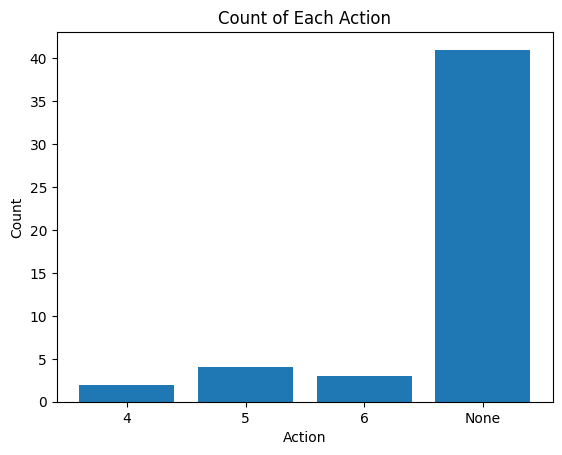

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt
# Define your mapping
mapping = {0: 4, 1: 5, 2: 6,3: 7}
actions = [action for trajectory in trajectory_list for action in trajectory['actions']]

# Apply the mapping to your actions
mapped_actions = [mapping[action] for action in actions]

# Count the occurrence of each mapped action
action_counts = Counter(mapped_actions)

# Print the counts
print(action_counts)

# Plot the counts
plt.bar(action_counts.keys(), action_counts.values())
plt.xlabel('Action')
plt.ylabel('Count')
plt.title('Count of Each Action')
labels = [str(i) if i != 7 else 'None' for i in mapping.values()]

# Set xticks
plt.xticks(list(mapping.values()),labels)

plt.show()

0.42178770899772644
3


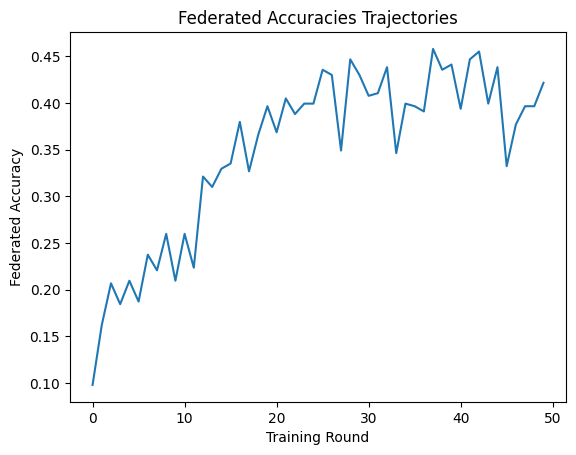

In [ ]:
# Extract federated averages from the trajectory_list
federated_accuracies = [fa for fed in trajectory_list for fa in fed['federated_accuracy']]
actions = [action for trajectory in trajectory_list for action in trajectory['actions']]

print(federated_accuracies[-1])
print(actions[-1])
# Plot the federated averages
plt.plot(federated_accuracies)
plt.xlabel('Training Round')
plt.ylabel('Federated Accuracy')
plt.title('Federated Accuracies Trajectories')
plt.show()

In [ ]:
np.zeros([10, 3])

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [ ]:
agent.q_table
# 0.6778711676597595
# 0.8095238208770752
# 0.7366946935653687
# 0.10084033757448196
# 0.09243697673082352
# 0.1568627506494522

array([[ 9.96188987e-05,  6.01876786e-04, -5.45574322e-05,
         2.62417905e-03]])

[[[[ 17.08418814  48.47601354   0.        ]
   [  0.           8.39237107   0.        ]
   [ 86.2928359   47.57428414   7.24406784]
   ...
   [181.57537593 230.0799386  255.        ]
   [220.97268089 255.         255.        ]
   [183.37879823 231.53759625 255.        ]]

  [[ 61.22927178   0.          11.85266119]
   [  0.           9.65850702   0.        ]
   [  0.          53.67158514  38.7247221 ]
   ...
   [181.25803884 224.80871629 240.84333401]
   [161.72718721 231.78453964 254.46360519]
   [229.26119236 255.         243.395874  ]]

  [[ 29.49817629   0.           0.        ]
   [ 73.50699038  16.47156385   0.        ]
   [ 33.9405283   15.07347324   0.        ]
   ...
   [251.94058119 222.05114788 209.22674074]
   [161.4565609  190.62123591 234.5141101 ]
   [180.78327861 255.         255.        ]]

  ...

  [[200.73245253 223.45364165 156.58954487]
   [227.15392136 190.17605023 197.73457861]
   [215.28390846 178.25900201  93.40456929]
   ...
   [255.         167.65924009 186.5

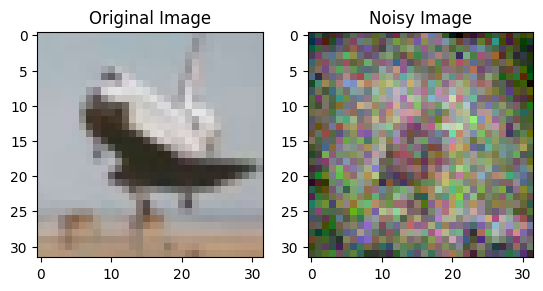

In [ ]:
import matplotlib.pyplot as plt
# Plot the original image
plt.subplot(1, 2, 1)
plt.imshow(x_train4[99])
plt.title('Original Image')

# Generate noise
noise = np.random.normal(loc=0.0, scale=25, size=x_train4.shape)
# Add noise to the image and clip the result
x_train_noisy_4 = np.clip(x_train4 + noise, 0.0, 255.0)
print(x_train_noisy_4)
# Plot the noisy image
plt.subplot(1, 2, 2)
plt.imshow(np.uint8(x_train_noisy_4)[9])
plt.title('Noisy Image')

plt.show()


In [ ]:
print(trajectory_list)

[{'observations': [array([0.09776536], dtype=float32)], 'actions': [0], 'reward': [array(0.03072625, dtype=float32)], 'federated_accuracy': [0.09776536375284195]}, {'observations': [array([0.16201118], dtype=float32)], 'actions': [3], 'reward': [array(0.06424581, dtype=float32)], 'federated_accuracy': [0.16201117634773254]}, {'observations': [array([0.20670392], dtype=float32)], 'actions': [3], 'reward': [array(0.04469274, dtype=float32)], 'federated_accuracy': [0.20670391619205475]}, {'observations': [array([0.18435754], dtype=float32)], 'actions': [3], 'reward': [array(-0.02234638, dtype=float32)], 'federated_accuracy': [0.18435753881931305]}, {'observations': [array([0.20949721], dtype=float32)], 'actions': [3], 'reward': [array(0.02513967, dtype=float32)], 'federated_accuracy': [0.20949721336364746]}, {'observations': [array([0.18715084], dtype=float32)], 'actions': [1], 'reward': [array(-0.02234638, dtype=float32)], 'federated_accuracy': [0.18715083599090576]}, {'observations': [a

In [ ]:
import pickle

# Save action_counts data
with open('dynamic.pickle', 'wb') as f:
    pickle.dump(trajectory_list, f)

In [ ]:
# file_path = 'tlaction7.pickle'
# with open(file_path, 'rb') as file:
#     # Deserialize the variable
#     load = pickle.load(file)
    
# print(load)